# Part1 Chpater03_04 얼굴 특징 분류

## 1. 샘플 이미지 데이터 불러오기

In [10]:
from glob import glob
from PIL import Image
import random

data_root = '../part1_chapter03_04'
filepath_list = list(glob(f"{data_root}/**/*.jpg"))
random.shuffle(filepath_list)

image_list = []
for idx in range(3):
    image_list.append(Image.open(filepath_list[idx]))

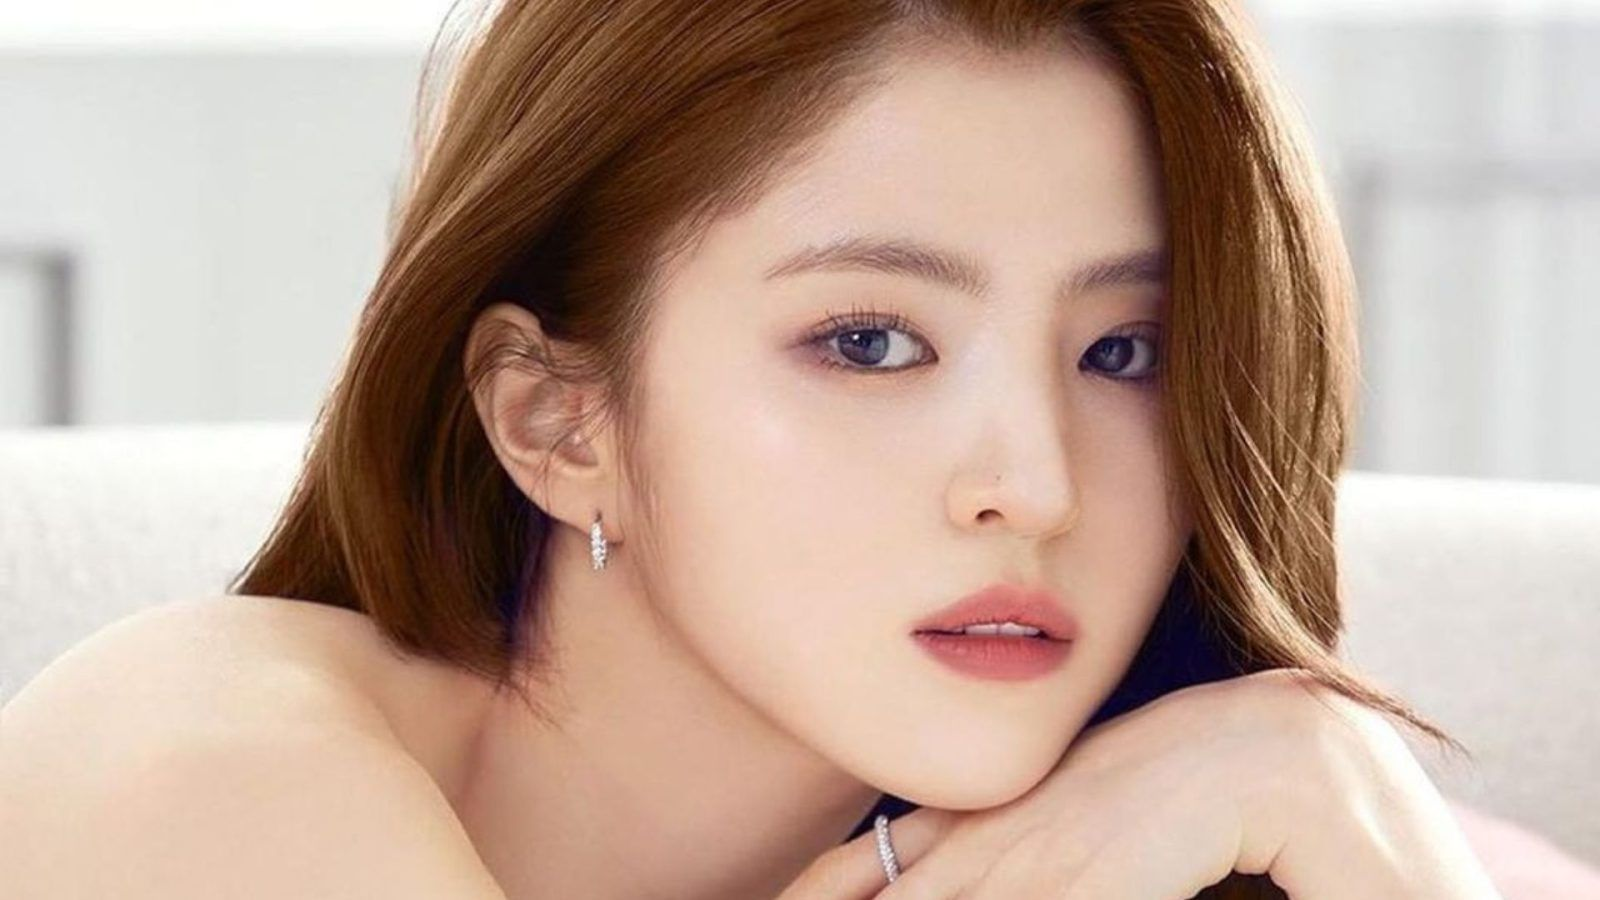

In [11]:
image_list[0]

# 2. Albumentations 라이브러리 설치
- [Document 링크](https://albumentations.ai) </br>
- API Reference 접근 </br>
    - 예시 코드: [링크](https://albumentations.ai/docs/examples/example/)
    - 클래스 명세서 : Document 탭 >> API Reference >> `Augmentations` >> `... transforms`

In [12]:
!pip3 install albumentations

# 3. 이미지 변환 테스트

In [60]:
import matplotlib.pyplot as plt
'''
    이미지 시각화 함수를 정의한다. 
'''

def visualize_images(image1, image2):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None 
    '''
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image1)
    axs[0].set_title('original')

    axs[1].imshow(image2)
    axs[1].set_title('transformed')
    
    plt.tight_layout()
    plt.show()

In [61]:
import albumentations as A
import numpy as np

sample_image = image_list[0]

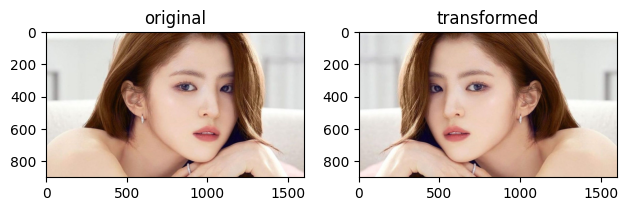

In [62]:
'''
    좌우 반전 테스트
'''
transform = A.HorizontalFlip(p=1.0)
transformed_image = transform(image=np.array(sample_image))['image']
visualize_images(sample_image, transformed_image)

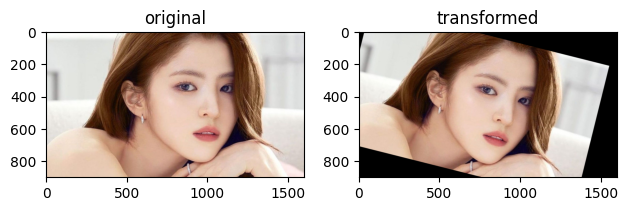

In [63]:
'''
    형태 변환 테스트
'''
transform = A.ShiftScaleRotate(p=1.0, border_mode=0)
# transform = A.OpticalDistortion(p=1.0, distort_limit=0.5)
# transform = A.GridDistortion(p=1.0)
transformed_image = transform(image=np.array(sample_image))['image']
visualize_images(sample_image, transformed_image)

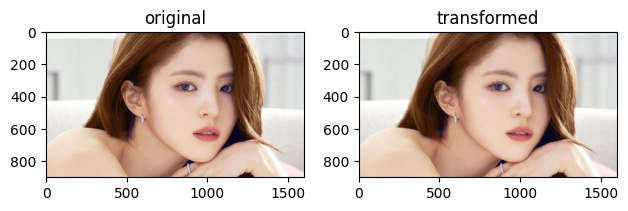

In [64]:
'''
    Blur 테스트
'''
transform = A.MotionBlur(p=1.0, blur_limit=(3, 5))
# transform = A.Blur(p=1.0, blur_limit=(3, 5))
transformed_image = transform(image=np.array(sample_image))['image']
visualize_images(sample_image, transformed_image)

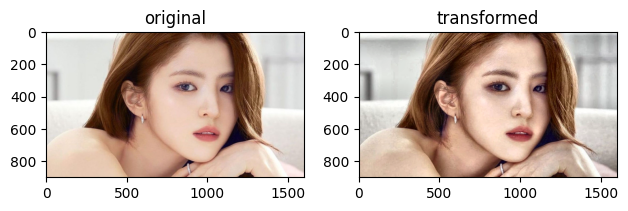

In [65]:
'''
    픽셀 값 변환
'''
transform = A.CLAHE(p=1.0)
# transform = A.ChannelShuffle(p=1.0)
# transform = A.ColorJitter(p=1.0)
transformed_image = transform(image=np.array(sample_image))['image']
visualize_images(sample_image, transformed_image)


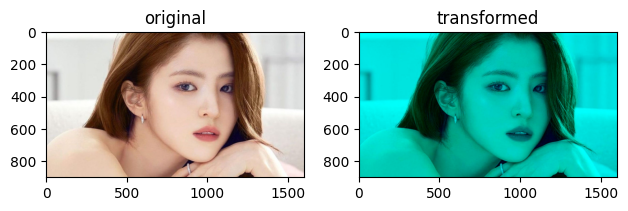

In [66]:
'''
    Dropout 테스트
'''
transform = A.ChannelDropout(p=1.0)
transformed_image = transform(image=np.array(sample_image))['image']
visualize_images(sample_image, transformed_image)

TypeError: Invalid shape (3, 224, 224) for image data

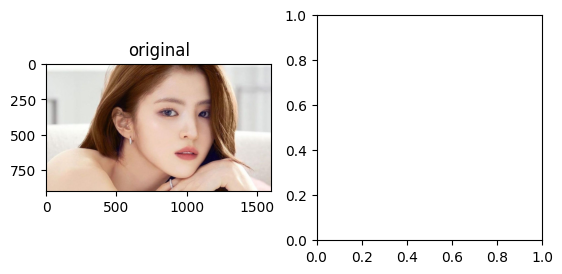

In [70]:
'''
    여러 transform 모듈을 하나로 합친다.
'''
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.CLAHE(p=0.5),
    A.Blur(p=0.5),
    A.ShiftScaleRotate(p=0.5, border_mode=0),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.Resize(height=224, width=224),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])
random.seed(42)

## Dataset 클래스에서 transform을 적용할 때 아래와 같은 코드로 변경 해야함
transformed_image = transform(image=np.array(sample_image))['image']

'''
    A.Normalize와 ToTensorV2를 적용했을 경우 아래의 시각화가 되지 않음.
'''
visualize_images(sample_image, transformed_image)

# 4. 이미지 역변환 (역정규화))

In [72]:
'''
    변환된 이미지 픽셀 값 확인
'''
transformed_image

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [73]:
import torch
from torchvision.transforms.functional import to_pil_image

def denormalize(tensor, mean, std):
    '''
        텐서를 역정규화 한다.
    '''
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    
    # 역정규화 수행
    tensor = tensor * std + mean
    
    # 텐서의 값 범위를 0과 1 사이로 조정합니다.
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

def tensor_to_pil(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    '''
        정규화된 텐서를 Pillow 이미지로 변환한다.
    '''
    # 역정규화
    tensor = denormalize(tensor, mean, std)
    
    # 텐서를 Pillow 이미지로 변환한다.
    pil_image = to_pil_image(tensor)
    
    return pil_image

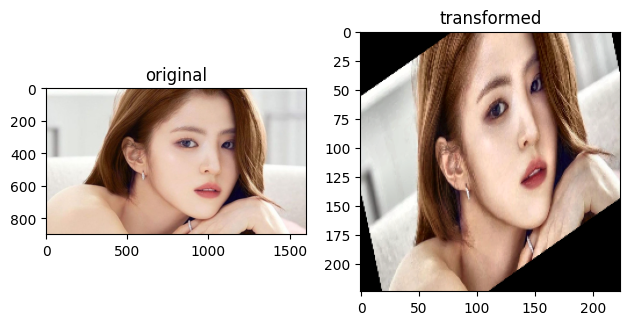

In [76]:
'''
    역정규화 한 이미지를 확인한다.
'''
unnormalized_image = tensor_to_pil(transformed_image)
visualize_images(sample_image, unnormalized_image)